In [1]:
import copy
import numpy as np
from Trip import Trip
from Point import Point
from Trips import Trips
import math
import matplotlib.pyplot as plt
import gurobipy as gb
from Simulation import Simulation
from Solver import Solver


In [3]:
n,m,ks,kr,kn,T_start,c=Simulation.get_simulation_number(0)

In [4]:
J,D=Simulation.initialize_map(n)

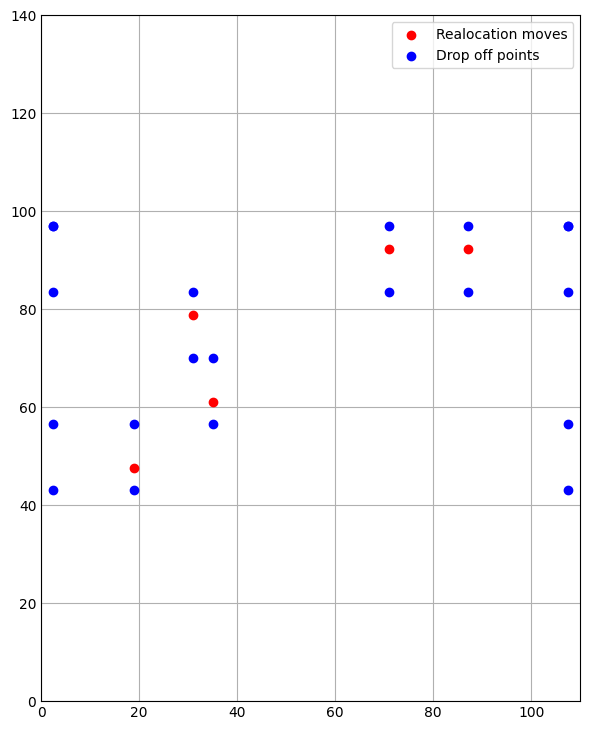

In [5]:
Simulation.plot_map(J,D,[],figsize=(5.5,7))

In [6]:
trips=Solver.cc_procedure(n,m,J,D,Point(0,0), Point(0,0))

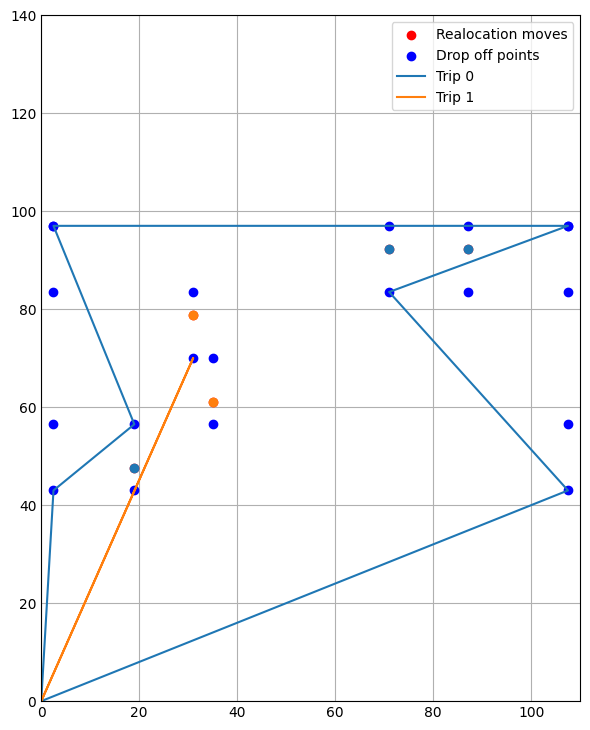

In [7]:
Simulation.plot_map(J,D,trips,figsize=(5.5,7))

In [8]:
new_trips=Solver.sam_matheuristic(n, m,J, D, trips)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-29
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17 rows, 14 columns and 35 nonzeros
Model fingerprint: 0xe312514e
Variable types: 2 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 153.2804128
Presolve removed 17 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 113.667 153.28 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.136666666667e+02, best bound 1.136666666667e+02, gap 0.0000%

Solution
Binary variables: 1, if relocation

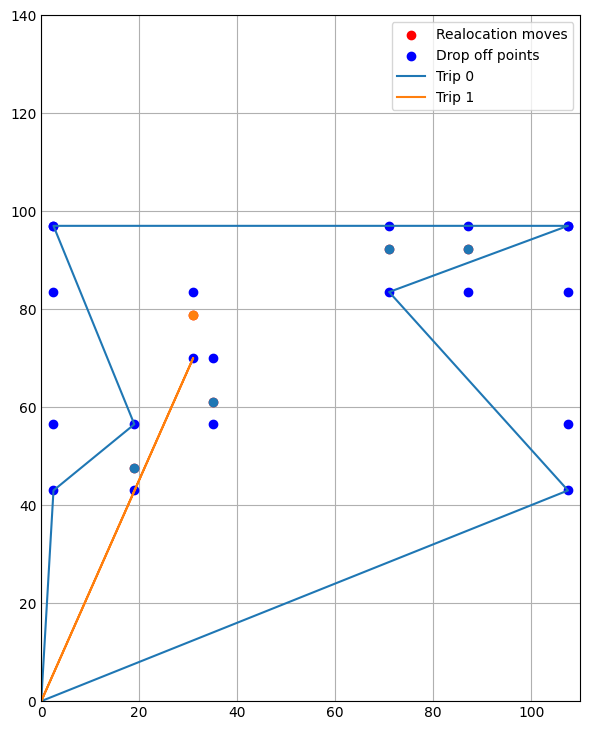

In [9]:
Simulation.plot_map(J,D,new_trips,figsize=(5.5,7))


In [10]:
trips_localsearch=local_search(trips,J,D,100000)


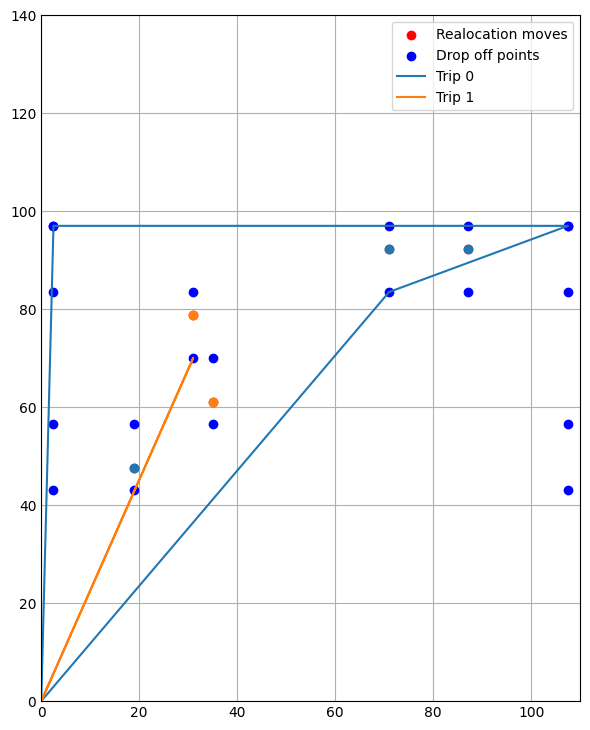

In [11]:
Simulation.plot_map(J,D,trips_localsearch,figsize=(5.5,7))


In [12]:
time_cc=Trips.get_total_duration(trips)
time_sam=Trips.get_total_duration(new_trips)
time_local_search=Trips.get_total_duration(trips_localsearch)
print(f"time cc = {time_cc}")
print(f"time sam = {time_sam}")
print(f"time localsearch = {time_local_search}")


time cc = 113.66666666666666
time sam = 113.66666666666666
time localsearch = 99.33333333333331
